In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
# import seaborn as sns
# sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
print ('# of training images:', len(os.listdir('train/images')))
print ('# of training masks:', len(os.listdir('train/masks')))
print ('# of test images:', len(os.listdir('test/images')))

# of training images: 4000
# of training masks: 4000
# of test images: 18000


In [3]:
os.listdir()

['sample_submission.csv',
 'ff kNN.ipynb',
 'EDA and LSTM tf.ipynb',
 'test.zip',
 'unet_resnet_pytorch.ipynb',
 'train',
 'depths.csv',
 'train.zip',
 '.ipynb_checkpoints',
 'unet_resnet_v0.model',
 'resnet_unet_v0.ipynb',
 'train.csv',
 'test',
 'EDA and LSTM.ipynb',
 'registryupload_1.csv',
 'unet_resnet_v0.csv',
 'kNN_rmse.csv',
 'kNN_results.csv',
 'registryupload_2.csv']

In [4]:
train_df = pd.read_csv('train.csv', index_col = 'id')
depths_df = pd.read_csv('depths.csv', index_col='id')
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)] # All depths not in train dataset are in 

print(len(train_df))
print(len(test_df))


4000
18000


In [6]:
# Load images into PIL format
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]
print(train_df.images)


id
575d24d81d    [[0.5254901960784314, 0.5137254901960784, 0.52...
a266a2a9df    [[0.3411764705882353, 0.3764705882352941, 0.33...
75efad62c1    [[0.5686274509803921, 0.4666666666666667, 0.32...
34e51dba6a    [[0.5411764705882353, 0.4745098039215686, 0.39...
4875705fb0    [[0.06666666666666667, 0.0784313725490196, 0.0...
782ae9b7e7    [[0.6078431372549019, 0.6196078431372549, 0.61...
9842f69f8d    [[0.4392156862745098, 0.4117647058823529, 0.4,...
aa94cfb806    [[0.5058823529411764, 0.49019607843137253, 0.4...
50d3073821    [[0.4666666666666667, 0.5333333333333333, 0.41...
28f865caaa    [[0.43137254901960786, 0.4392156862745098, 0.4...
b5e1371b3b    [[0.4117647058823529, 0.4196078431372549, 0.43...
57e394bc67    [[0.4, 0.396078431372549, 0.4, 0.4431372549019...
b45ad3932e    [[0.43137254901960786, 0.4117647058823529, 0.4...
ef51bbcde7    [[0.4, 0.396078431372549, 0.38823529411764707,...
d4d34af4f7    [[0.3607843137254902, 0.3843137254901961, 0.42...
302ea1ac81    [[0.18823529411764706,

In [6]:
# Load masks into PIL format
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

# Coverage of a mask is defined as how many pixels contain salt
image_size = 101
train_df["coverage"] = train_df.masks.map(np.sum) / pow(image_size, 2)

# Coverage class is defined by coverage
def coverage_to_class(x):
    for i in range(0,11):
        if x*10 <= i:
            return i
train_df["coverage_class"] = train_df.coverage.map(coverage_to_class)

In [7]:
# fig, axs = plt.subplots(1, 2, figsize=(15,5))
# sns.distplot(train_df.coverage, kde=False, ax=axs[0])

In [8]:
# Create train/val split by stratifying on coverage class
# TODO: Try different coverage class splits, use stratified folds?, try different test sizes
img_size_target = 101

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [9]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x



In [10]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [11]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric =[]
    for batch in range(batch_size):
        t, p = A[batch] > 0, B[batch] > 0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t,p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

# tf.py_func(my_func, [input], tf.float32)
def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [12]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [13]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_train.shape)


(6400, 101, 101, 1)
(6400, 101, 101, 1)


In [4]:
help(np.fliplr)

Help on function fliplr in module numpy.lib.twodim_base:

fliplr(m)
    Flip array in the left/right direction.
    
    Flip the entries in each row in the left/right direction.
    Columns are preserved, but appear in a different order than before.
    
    Parameters
    ----------
    m : array_like
        Input array, must be at least 2-D.
    
    Returns
    -------
    f : ndarray
        A view of `m` with the columns reversed.  Since a view
        is returned, this operation is :math:`\mathcal O(1)`.
    
    See Also
    --------
    flipud : Flip array in the up/down direction.
    rot90 : Rotate array counterclockwise.
    
    Notes
    -----
    Equivalent to m[:,::-1]. Requires the array to be at least 2-D.
    
    Examples
    --------
    >>> A = np.diag([1.,2.,3.])
    >>> A
    array([[ 1.,  0.,  0.],
           [ 0.,  2.,  0.],
           [ 0.,  0.,  3.]])
    >>> np.fliplr(A)
    array([[ 0.,  0.,  1.],
           [ 0.,  2.,  0.],
           [ 3.,  0.,  0.]])
 

In [14]:
# Main model
input_layer = Input((img_size_target, img_size_target, 1)) # Instantiates a Keras tensor (using TF backend)
output_layer = build_model(input_layer, 16, 1) # TODO: Why 16 start neurons? Why 1 for dropout ratio?

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
save_model_name = 'unet_resnet_v0.model'

model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 95s - loss: 0.4385 - my_iou_metric: 0.3084 - val_loss: 2.1780 - val_my_iou_metric: 0.1529

Epoch 00001: my_iou_metric improved from -inf to 0.30844, saving model to unet_resnet_v0.model
Epoch 2/50
 - 83s - loss: 0.3838 - my_iou_metric: 0.4466 - val_loss: 1.5125 - val_my_iou_metric: 0.3800

Epoch 00002: my_iou_metric improved from 0.30844 to 0.44661, saving model to unet_resnet_v0.model
Epoch 3/50
 - 83s - loss: 0.3425 - my_iou_metric: 0.4879 - val_loss: 0.9529 - val_my_iou_metric: 0.0656

Epoch 00003: my_iou_metric improved from 0.44661 to 0.48789, saving model to unet_resnet_v0.model
Epoch 4/50
 - 83s - loss: 0.3263 - my_iou_metric: 0.4979 - val_loss: 2.2707 - val_my_iou_metric: 0.4031

Epoch 00004: my_iou_metric improved from 0.48789 to 0.49794, saving model to unet_resnet_v0.model
Epoch 5/50
 - 84s - loss: 0.2720 - my_iou_metric: 0.5670 - val_loss: 0.2761 - val_my_iou_metric: 0.5541

Epoch 00005: my_iou_metric improved fro

Epoch 44/50
 - 83s - loss: 0.0712 - my_iou_metric: 0.7867 - val_loss: 0.9874 - val_my_iou_metric: 0.4556

Epoch 00044: my_iou_metric did not improve from 0.82508
Epoch 45/50
 - 83s - loss: 0.0638 - my_iou_metric: 0.7962 - val_loss: 0.1886 - val_my_iou_metric: 0.7390

Epoch 00045: my_iou_metric did not improve from 0.82508
Epoch 46/50
 - 83s - loss: 0.0504 - my_iou_metric: 0.8167 - val_loss: 0.2444 - val_my_iou_metric: 0.7396

Epoch 00046: my_iou_metric did not improve from 0.82508
Epoch 47/50
 - 83s - loss: 0.0421 - my_iou_metric: 0.8348 - val_loss: 0.2051 - val_my_iou_metric: 0.7324

Epoch 00047: my_iou_metric improved from 0.82508 to 0.83478, saving model to unet_resnet_v0.model
Epoch 48/50
 - 83s - loss: 0.0380 - my_iou_metric: 0.8375 - val_loss: 0.2024 - val_my_iou_metric: 0.7271

Epoch 00048: my_iou_metric improved from 0.83478 to 0.83748, saving model to unet_resnet_v0.model
Epoch 49/50
 - 83s - loss: 0.0376 - my_iou_metric: 0.8412 - val_loss: 0.2074 - val_my_iou_metric: 0.7324



In [15]:
# import tensorflow as tf
# # Creates a graph.
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(c))

[[22. 28.]
 [49. 64.]]


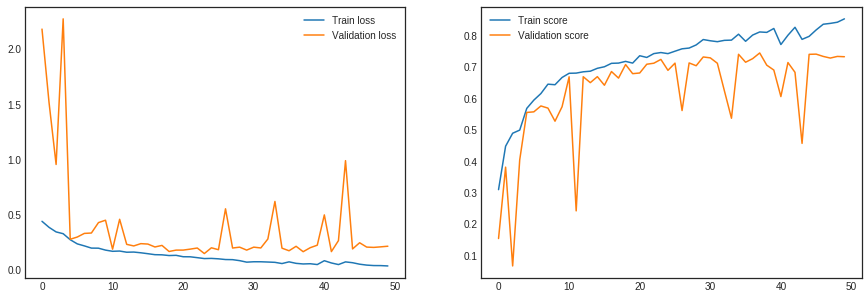

In [19]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

In [20]:
model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric,
                                                   'lovasz_loss': lovasz_loss})

In [21]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [22]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [23]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125
 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125
 0.54225  0.6135   0.65475  0.697625 0.711125 0.73125  0.742875 0.752625
 0.755    0.75775  0.753875 0.74975  0.74675  0.736    0.72075 ]


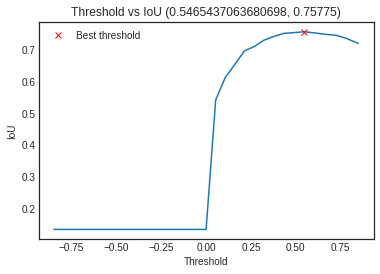

In [25]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [26]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [28]:
x_test = np.array([(np.array(load_img("test/images/{}.png".format(idx), color_mode="grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [29]:
preds_test = predict_result(model,x_test,img_size_target)

In [31]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 7.351572513580322 s


In [32]:
submission_file = 'unet_resnet_v0.csv'

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)